##### prepared_data.csv - after deleting short sentences, unknown words

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import re

1.6.0


### Load word vectors. 400000 соответствий слово -> число

In [2]:
wordsList = np.load('wordsList.npy')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')

### Load data raw data

In [158]:
#Load data
raw_data = pd.read_csv("text_emotion.csv")
keep_col = ['sentiment','content']
df = raw_data[keep_col]
# print("Raw data head:", df.head(100))
# print("Number of tweets grouped by sentiment:", df.groupby(['sentiment']).count())

 # Data Preparation

### Split familiar categories

In [159]:
for index, row in df.iterrows():
    if (row["sentiment"] == "hate"):
        row["sentiment"] = "anger"
    if (row["sentiment"] == "boredom" or row["sentiment"] == "empty"):
        row["sentiment"] = "sadness"
    if (row["sentiment"] == "happiness" or row["sentiment"] == "relief" or row["sentiment"] == "enthusiasm"):
        row["sentiment"] = "fun"
        
print("Number of tweets grouped by sentiment:", df.groupby(['sentiment']).count())

Number of tweets grouped by sentiment:            content
sentiment         
anger         1433
fun           9270
love          3842
neutral       8638
sadness       6171
surprise      2187
worry         8459


### Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [160]:
#Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    string = re.sub(r'@\w+','',string)                                      # Delete @* references
    string = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+',' ', string) # Delete http(s):// links
    string = re.sub(r'\.+',' ', string)                                     # Replace ... with ' '
    return re.sub(strip_special_chars, "", string.lower())

for index, row in df.iterrows():
    row["content"] = cleanSentences(row["content"])
    
# print("Raw data head:", df.head(100))

### Sentence length hist

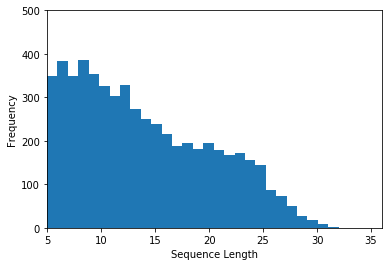

In [224]:
numWords = []

for index, row in df.iterrows():
    numWords.append(len(row["content"].split()))

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 28)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([5, 36, 0, 500])
plt.show()

### Удаление из датасета всех предложений, где есть неизвестные слова

In [162]:
unknownWordCounter = 0
for index, row in df.iterrows():
    split = row["content"].split()
    for word in split:
            if word not in wordsList:
                unknownWordCounter = unknownWordCounter + 1
                df.drop(index, inplace=True)
                break
print("Number of unknown words:", unknownWordCounter)

print("Number of tweets grouped by sentiment:", df.groupby(['sentiment']).count())

/home/valentin/anaconda3/envs/tensorflow-v1.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Number of unknown words: 12870
Number of tweets grouped by sentiment:            content
sentiment         
anger          920
fun           5945
love          2466
neutral       5980
sadness       4376
surprise      1446
worry         5997


### Удаление предложений с количеством слов < 5

In [166]:
for index, row in df.iterrows():
    split = row["content"].split()
    if len(split) < 5:
        df.drop(index, inplace=True)
print("Number of tweets grouped by sentiment:", df.groupby(['sentiment']).count())

/home/valentin/anaconda3/envs/tensorflow-v1.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Number of tweets grouped by sentiment:            content
sentiment         
anger          827
fun           5266
love          2115
neutral       4527
sadness       3826
surprise      1259
worry         5413


### Сохранение готовых данных

In [1]:
print(df.head(100))
df.to_csv('prepared_data.csv', sep='\t', encoding='utf-8')
len(df.index)

NameError: name 'df' is not defined

### Create grouped grouped_data.csv with 800 sentence instances of each sentiment

In [3]:
df = pd.read_csv("prepared_data.csv", sep='\t')
keep_col = ['sentiment','content']
df = df[keep_col]
print(len(df.index))
grouped = df.groupby('sentiment')
anger_group = grouped.get_group('anger')
fun_group = grouped.get_group('fun')
love_group = grouped.get_group('love')
sadness_group = grouped.get_group('sadness')
surprise_group = grouped.get_group('surprise')

def getGroupHead(DataFrame):
    return DataFrame.head(800)

anger_group = getGroupHead(anger_group)
fun_group = getGroupHead(fun_group)
love_group = getGroupHead(love_group)
sadness_group = getGroupHead(sadness_group)
surprise_group = getGroupHead(surprise_group)

frames = [anger_group, fun_group, love_group, sadness_group, surprise_group]

df = pd.concat(frames)

type(anger_group)
print(len(df.index))

df.to_csv('grouped_data.csv', sep='\t', encoding='utf-8')

23233
4000


### Преобразование предложений в вектора

In [4]:
numFiles = 4000
maxSeqLength = 30
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for index, row in df.iterrows():
    indexCounter = 0
    split = row["content"].split()
    for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
    fileCounter = fileCounter + 1
    
print(ids)

[[    20     14    100 ...      0      0      0]
 [109542  45120  10946 ...      0      0      0]
 [    37   2557    646 ...      0      0      0]
 ...
 [    54     81    733 ...      0      0      0]
 [ 28125     33      4 ...      0      0      0]
 [    41    180      4 ...      0      0      0]]


In [5]:
print(ids[0])
print(ids[3999])

[    20     14    100  17249     61     67   2383  22392     13     71
    951      6 201534    699      3 201534    364      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[    41    180      4     30  79289    751      7    306    494   1052
      6 261038    839  14663      7    202    941      0      0      0
      0      0      0      0      0      0      0      0      0      0]


### Функции получение batch для тренировки

In [6]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        r = randint(1,699)
        if (i % 5 == 0):
            num = r
            labels.append([1,0,0,0,0])
        if (i % 5 == 1): 
            num = 800 + r
            labels.append([0,1,0,0,0])
        if (i % 5 == 2): 
            num = 1600 + r
            labels.append([0,0,1,0,0])
        if (i % 5 == 3): 
            num = 2400 + r
            labels.append([0,0,0,1,0])
        if (i % 5 == 4): 
            num = 3200 + r
            labels.append([0,0,0,0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        r = randint(699,799)
        if (i % 6 == 0):
            num = r
            labels.append([1,0,0,0,0])
        if (i % 6 == 1): 
            num = 800 + r
            labels.append([0,1,0,0,0])
        if (i % 6 == 2): 
            num = 1600 + r
            labels.append([0,0,1,0,0])
        if (i % 6 == 3): 
            num = 2400 + r
            labels.append([0,0,0,1,0])
        if (i % 6 == 4): 
            num = 3200 + r
            labels.append([0,0,0,0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

### NN's parameters

In [7]:
batchSize = 28
lstmUnits = 64
numClasses = 5
iterations = 100000
numDimensions = 300

import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight, name="lstm_prediction") + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)
sess = tf.InteractiveSession()
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train

In [8]:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)
    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/five_dimensions.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

saved to models/five_dimensions.ckpt-10000
saved to models/five_dimensions.ckpt-20000
saved to models/five_dimensions.ckpt-30000
saved to models/five_dimensions.ckpt-40000
saved to models/five_dimensions.ckpt-50000
saved to models/five_dimensions.ckpt-60000
saved to models/five_dimensions.ckpt-70000
saved to models/five_dimensions.ckpt-80000
saved to models/five_dimensions.ckpt-90000


# Check

In [9]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix


inputText = "That movie was terrible."
inputMatrix = getSentenceMatrix(inputText)

predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]

print(predictedSentiment)
#anger, fun, love, sadness, surprise


# This was the worst thing ever happened with me --sandess
# I have really a nice time today playing football --love
# I like autumn evenings for it's atmosphere --love
# I love you --love
# I hate you --anger
# Have a nice day! --love
# I hope you die --sadness
# I never was so tired like now, I want this all go to end --sadness
# Wow, i never expect the elephant is too big --surprise
# Let's go party! --surprise
# Omg, are you kidding me? --surprise
# I lose all my money today on Poker --fun
# The sky so heavy --sadness
# When I this about future of Russia it's getting cold in my soul --surprise
# Wash it all away --surprise
# Wake me up, when september ends --sadness
# We are looking for you to start up a fight --surprise
# There's no money there's no possessions Only obsession I don't need that shit Take my money take my obsession --anger --surprise


# https://www.fluentu.com/blog/english/advanced-english-phrases/
# She’s flying high after the successful product launch. --fun
# He’s pumped up for his first half-marathon race this weekend. --love
# I always feel down in the dumps when I go back to work after a long weekend. --sadness
# I just asked one question to confirm his request, and my boss bit my head off. --anger

INFO:tensorflow:Restoring parameters from models/five_dimensions.ckpt-90000
[12.183834  -1.6347973 -1.3660951 -1.1432288 -1.7402791]


In [12]:
inputText = "I have really a nice time today playing football"
inputMatrix = getSentenceMatrix(inputText)

predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]

print(predictedSentiment)

[-2.858811  14.350354  -4.1434903 -2.6799266 -2.3185062]


Были убраны некоторые категории, некоторые склеены. Проведена подготовка данных, убраны лишние знаки препинания, ссылки, данные преобразованы в целочисленный вектор значений. Удалены слишком короткие предложения и предложения с неизвестными словами